[1.         0.99993834 0.99987667 ... 0.09475175 0.10501585 0.11527995]


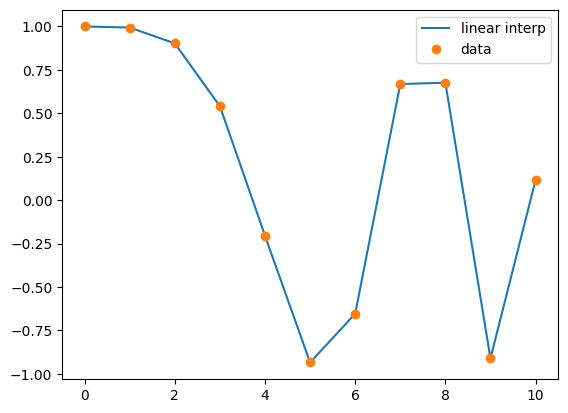

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 10, num=11)

y = np.cos(-x**2 / 9.0)

xnew = np.linspace(0, 10, num=1001)

ynew = np.interp(xnew, x, y)
print(ynew)


plt.plot(xnew, ynew, '-', label='linear interp')

plt.plot(x, y, 'o', label='data')

plt.legend(loc='best')

plt.show()


In [2]:
import json

with open('../data/app/input-data.jsons', 'r') as datafile:
  line1 = datafile.readline()
  v = json.loads(line1)
  print(v)
  for [i, line] in enumerate(datafile.readlines()):
    with open(f'../data/app/input-{i}.json', 'w') as wfile:
      wfile.write(line)



{'accelerometerData': [{'time': None, 'x': None, 'y': None, 'z': None, 'ms': None}], 'gyroscopeData': [{'time': None, 'x': None, 'y': None, 'z': None, 'ms': None}], 'gpsData': [{'time': None, 'latitude': None, 'longitude': None, 'accuracy': None, 'ms': None}, {'time': '2024-04-10T21:29:45.595159', 'latitude': 59.7248667, 'longitude': 30.5406517, 'accuracy': 3.9000000953674316, 'ms': None}]}


In [3]:
import pandas
import datetime

path = '../data/app/input-6.json'

def obj_set_time_to_int(obj):
  if (obj['time'] is not None):
    obj['time'] = int(datetime.datetime.fromisoformat(obj['time']).timestamp() * 1000000)
  return obj

with open(path) as file:
  data = json.loads(file.readline())
  accelerometerData = map(obj_set_time_to_int, data['accelerometerData'])
  gyroscopeData = map(obj_set_time_to_int, data['gyroscopeData'])
  gpsData = map(obj_set_time_to_int, data['gpsData'])

  acDf = pandas.DataFrame([o for o in accelerometerData])
  gyDf = pandas.DataFrame([o for o in gyroscopeData])
  gpsDf = pandas.DataFrame([o for o in gpsData])
  
  print(acDf, gyDf, gpsDf, sep='\n')
  print(acDf.dtypes, gyDf.dtypes, gpsDf.dtypes, sep='\n')

                 time      x      y      z  ms
0    1712773863632297 -0.106 -0.362 -0.227  38
1    1712773863653905 -0.059  0.347  0.054  20
2    1712773863673282  0.072 -0.030  0.484  20
3    1712773863708596  0.032  0.380 -0.664  35
4    1712773863733369 -0.135 -0.646 -0.108  24
..                ...    ...    ...    ...  ..
315  1712773878481441  0.475 -0.004  0.432  27
316  1712773878514009 -0.338 -0.249 -0.070  32
317  1712773878556055  0.176  0.464 -0.724  40
318  1712773878573868 -0.167 -1.053 -0.207  40
319  1712773878596430 -0.414  0.138 -0.222  22

[320 rows x 5 columns]
                 time         x         y         z  ms
0    1712773863632483 -0.066413  0.089787 -0.026400  38
1    1712773863660768  0.061875  0.054313 -0.011825  27
2    1712773863670577 -0.093363 -0.007975  0.005362  27
3    1712773863693931  0.080163 -0.056925  0.012650  23
4    1712773863727374 -0.065175 -0.100787 -0.011825  33
..                ...       ...       ...       ...  ..
319  171277387847409

/tmp/ipykernel_1427987/3845035048.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


In [4]:
acDfc = acDf[acDf.ms.notna()]
gyDfc = gyDf[gyDf.ms.notna()]
gpsDfc = gpsDf[gpsDf.ms.notna()]

print(acDfc, gyDfc, gpsDfc, sep='\n')

                 time      x      y      z  ms
0    1712773863632297 -0.106 -0.362 -0.227  38
1    1712773863653905 -0.059  0.347  0.054  20
2    1712773863673282  0.072 -0.030  0.484  20
3    1712773863708596  0.032  0.380 -0.664  35
4    1712773863733369 -0.135 -0.646 -0.108  24
..                ...    ...    ...    ...  ..
315  1712773878481441  0.475 -0.004  0.432  27
316  1712773878514009 -0.338 -0.249 -0.070  32
317  1712773878556055  0.176  0.464 -0.724  40
318  1712773878573868 -0.167 -1.053 -0.207  40
319  1712773878596430 -0.414  0.138 -0.222  22

[320 rows x 5 columns]
                 time         x         y         z  ms
0    1712773863632483 -0.066413  0.089787 -0.026400  38
1    1712773863660768  0.061875  0.054313 -0.011825  27
2    1712773863670577 -0.093363 -0.007975  0.005362  27
3    1712773863693931  0.080163 -0.056925  0.012650  23
4    1712773863727374 -0.065175 -0.100787 -0.011825  33
..                ...       ...       ...       ...  ..
319  171277387847409

In [9]:
import pandas
import numpy
from scipy.signal import lfilter, iirfilter

tick = 25000
window = 128
slide = 0.5
fs = 1000000 / tick
filter_N = 2
filter_freq = 10

def get_df_time_range(df: pandas.DataFrame):
    l = len(df.index)
    return (df.iloc[0].time, df.iloc[l - 1].time, l)


def get_diff_time(start: int, end: int):
    return end - start

def interpolate(
    acDf: pandas.DataFrame, gyDf: pandas.DataFrame, gpsDf: pandas.DataFrame
):
    acTse = get_df_time_range(acDf)
    gyTse = get_df_time_range(gyDf)
    gpsTse = get_df_time_range(gpsDf)

    minTime = int(max(acTse[0], gyTse[0], gpsTse[0]))
    maxTime = int(min(acTse[1], gyTse[1], gpsTse[1]))

    sensorInterpTimes = np.arange(minTime, maxTime, tick)
    # print(sensorInterpTimes, len(sensorInterpTimes), sep="\n")

    gpsInterpTimes = np.arange(
        minTime + int(tick * window * slide / 2),
        maxTime + int(tick * window * slide / 2),
        int(tick * window * slide),
    )
    # print(gpsInterpTimes, len(gpsInterpTimes), sep="\n")

    acTimes = acDf.time.to_numpy()
    gyTimes = gyDf.time.to_numpy()
    gpsTimes = gpsDf.time.to_numpy()

    acX = acDf.x.to_numpy()
    acY = acDf.y.to_numpy()
    acZ = acDf.z.to_numpy()

    gyX = gyDf.x.to_numpy()
    gyY = gyDf.y.to_numpy()
    gyZ = gyDf.z.to_numpy()

    acXi = np.interp(sensorInterpTimes, acTimes, acX)
    acYi = np.interp(sensorInterpTimes, acTimes, acY)
    acZi = np.interp(sensorInterpTimes, acTimes, acZ)
    gyXi = np.interp(sensorInterpTimes, gyTimes, gyX)
    gyYi = np.interp(sensorInterpTimes, gyTimes, gyY)
    gyZi = np.interp(sensorInterpTimes, gyTimes, gyZ)

    gpsLat = gpsDf.latitude.to_numpy()
    gpsLon = gpsDf.longitude.to_numpy()

    gpsLoni = np.interp(gpsInterpTimes, gpsTimes, gpsLon)
    gpsLati = np.interp(gpsInterpTimes, gpsTimes, gpsLat)

    acDf1 = pandas.DataFrame(
        {"time": sensorInterpTimes, "x": acXi, "y": acYi, "z": acZi}
    )
    gyDf1 = pandas.DataFrame(
        {"time": sensorInterpTimes, "x": gyXi, "y": gyYi, "z": gyZi}
    )
    gpsDf1 = pandas.DataFrame(
        {"time": gpsInterpTimes, "latitude": gpsLati, "longitude": gpsLoni}
    )

    return (acDf1, gyDf1, gpsDf1)

def reduce_noice(acDf: pandas.DataFrame, gyDf: pandas.DataFrame):
    b, a = iirfilter(filter_N, Wn=filter_freq, fs=fs, btype="low", ftype="butter")

    acX = lfilter(b, a, acDf.x)
    acY = lfilter(b, a, acDf.y)
    acZ = lfilter(b, a, acDf.z)

    gyX = lfilter(b, a, gyDf.x)
    gyY = lfilter(b, a, gyDf.y)
    gyZ = lfilter(b, a, gyDf.z)

    acDf1 = pandas.DataFrame({"time": acDf.time, "x": acX, "y": acY, "z": acZ})
    gyDf1 = pandas.DataFrame({"time": gyDf.time, "x": gyX, "y": gyY, "z": gyZ})

    return (acDf1, gyDf1)
    # acil = (acXil**2 + acYil**2 + acZil**2) ** 0.5
    # gyil = (gyXil**2 + gyYil**2 + gyZil**2) ** 0.5


# (acDfi, gyDfi, gpsDfi) = processing.interpolate(acDfc, gyDfc, gpsDfc)
# (acDfn, gyDfn) = reduce_noice(acDfi, gyDfi)
# acDfr, gyDfr, gpsDfr = acDfn, gyDfn, gpsDfi

(acDfi, gyDfi) = reduce_noice(acDfc, gyDfc)
(acDfj, gyDfj, gpsDfj) = interpolate(acDfi, gyDfi, gpsDfc)
acDfr, gyDfr, gpsDfr = acDfj, gyDfj, gpsDfj


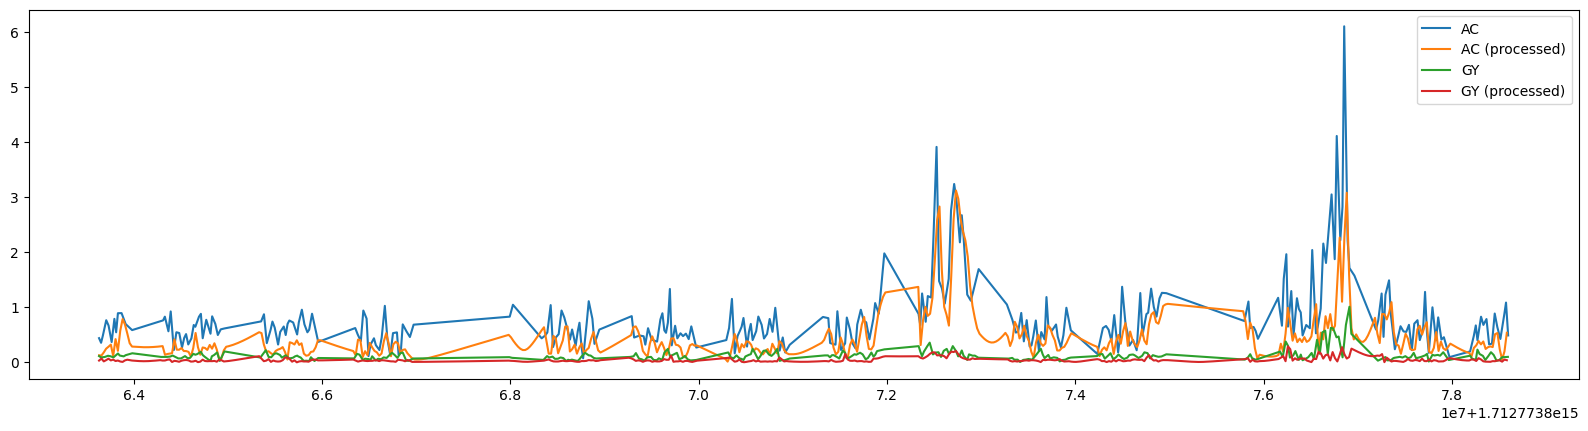

In [10]:
# initial values
acTimes = acDfc.time.to_numpy()
acX = acDfc.x.to_numpy()
acY = acDfc.y.to_numpy()
acZ = acDfc.z.to_numpy()

ac = (acX ** 2 + acY ** 2 + acZ ** 2) ** 0.5

gyTimes = gyDfc.time.to_numpy()
gyX = gyDfc.x.to_numpy()
gyY = gyDfc.y.to_numpy()
gyZ = gyDfc.z.to_numpy()

gy = (gyX ** 2 + gyY ** 2 + gyZ ** 2) ** 0.5


# processed values
acTimesi = acDfr.time.to_numpy()
acXi = acDfr.x.to_numpy()
acYi = acDfr.y.to_numpy()
acZi = acDfr.z.to_numpy()

aci = (acXi ** 2 + acYi ** 2 + acZi ** 2) ** 0.5

gyTimesi = gyDfr.time.to_numpy()  
gyXi = gyDfr.x.to_numpy()
gyYi = gyDfr.y.to_numpy()
gyZi = gyDfr.z.to_numpy()

gyi = (gyXi ** 2 + gyYi ** 2 + gyZi ** 2) ** 0.5

plt.figure().set_figwidth(20)
plt.plot(acTimes, ac, '-', label="AC")
plt.plot(acTimesi, aci, '-', label="AC (processed)")

plt.plot(gyTimes, gy, '-', label="GY")
plt.plot(gyTimesi, gyi, '-', label="GY (processed)")

plt.legend()